In [1]:
import csv
import json
import numpy as np
from shapely.geometry import Polygon, Point

import matplotlib.pyplot as plt
from matplotlib.path import Path

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pyslabgrid import polygon as pol

### Work out sub - zones based on the mid-slab configurations

Based on 40 km depth boundary, two sub-zones are defined in each subduction zones.The depths <= 40 km is the flat zone while below 40 km is steep zone.

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

In [3]:
def get_xbounds(szone):
    finterp_file = {'hik': '../subduction-model/finterp/hik_finterp.npy',
                    'puy': '../subduction-model/finterp/puy_finterp.npy'}
    finterp = np.load(finterp_file[szone], allow_pickle=True)[()]   
    xbounds = finterp['xbounds']
    return xbounds
    
# maxdepth for hikurangi = 250, for puysegur = 180
def read_gridfile(gridfile, szone, maxdepth=250):
    x,y,z = [],[],[]
    with open(gridfile, 'r') as f:
        csvreader = csv.reader(f)
        header = next(csvreader)
        for row in csvreader:
            if float(row[2])>maxdepth:
                continue
            x.append(float(row[0]))
            y.append(float(row[1]))
            z.append(float(row[2]))   
    return x,y,z

def get_gridpoints(szone, maxdepth=250):
    files = {'puy': '../02midslab-config/grids/puy-500m-grids/puy-midslab_500m_grid.csv',
             'hik': '../02midslab-config/grids/hik-500m-grids/hik-midslab_500m_grid.csv',}

    x,y,z = read_gridfile(files[szone], szone, maxdepth)
    points = np.vstack((x,y)).T 
    xbounds = get_xbounds(szone)
    blon, blat = xbounds.exterior.coords.xy
    tupVerts = []
    for tx,ty in zip(blon, blat):
        tupVerts.append((tx,ty))
    pbounds = Path(tupVerts) # make a polygon
    indx = pbounds.contains_points(points)
    x, y, z = np.array(x), np.array(y), np.array(z)
    x, y, z = x[indx].tolist(), y[indx].tolist(), z[indx].tolist()
    return(x,y,z)

# hik_x+puy_x, hik_y+puy_y, c=hik_z+puy_z
def get_zones(X,Y,Z):
    x_flat, y_flat, z_flat = [],[],[]
    x_steep, y_steep,z_steep= [],[],[]
    for x,y,z in zip(X,Y,Z):
        if z>40:
            x_steep.append(x)
            y_steep.append(y)
            z_steep.append(z)
        else:
            x_flat.append(x)
            y_flat.append(y)
            z_flat.append(z)
        
    blon_flat, blat_flat = pol.boundary(x_flat, y_flat, alpha =0.25, only_outer = True)
    blon_steep, blat_steep = pol.boundary(x_steep, y_steep, alpha =0.25, only_outer = True)
    return (blon_flat, blat_flat, blon_steep, blat_steep)

# hik_x+puy_x, hik_y+puy_y, c=hik_z+puy_z
def get_wholezone(X,Y,Z):
    blon, blat = pol.boundary(X, Y, alpha =0.25, only_outer = True)
    return (blon, blat)

In [5]:
files = {'puy': '../02midslab-config/grids/puy-500m-grids/puy-midslab_500m_grid.csv',
         'hik': '../02midslab-config/grids/hik-500m-grids/hik-midslab_500m_grid.csv',}

# These grid files are HUGE and hence stored in .zip (or .tar.nz) formats
# now, one can unzip them either manually or through codes
# I am doing the former. 

puy_x,puy_y,puy_z = get_gridpoints('puy', maxdepth=150)
hik_x,hik_y,hik_z = get_gridpoints('hik', maxdepth=250)

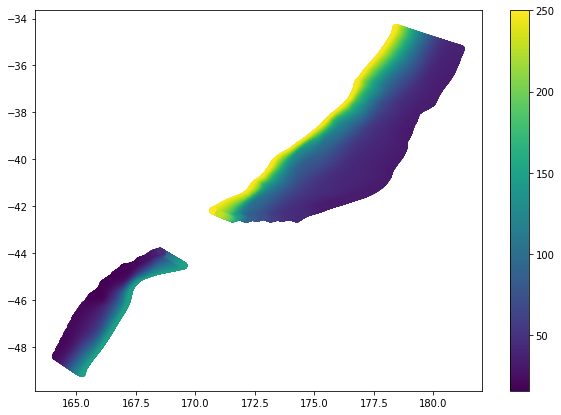

In [6]:
plt.figure(figsize=(10,7))
plt.scatter(hik_x+puy_x, hik_y+puy_y, c=hik_z+puy_z)
plt.colorbar();
plt.show()

In [7]:
blon_flat_hik, blat_flat_hik, blon_steep_hik, blat_steep_hik = \
                                        get_zones(hik_x,hik_y,hik_z)
blon_flat_puy, blat_flat_puy, blon_steep_puy, blat_steep_puy, = \
                                        get_zones(puy_x,puy_y,puy_z)

blon_whole_hik, blat_whole_hik = get_wholezone(hik_x,hik_y,hik_z)
blon_whole_puy, blat_whole_puy = get_wholezone(puy_x,puy_y,puy_z)

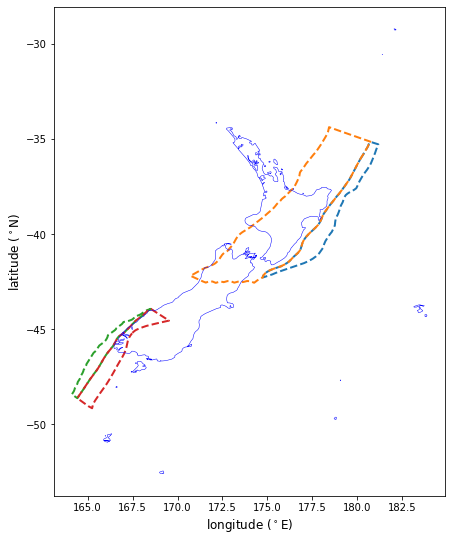

In [8]:
fig, ax = plt.subplots(figsize=(7,9))
#plt.scatter(X, Y, c=Z)
ax.plot(blon_flat_hik, blat_flat_hik, '--', linewidth= 2)
ax.plot(blon_steep_hik, blat_steep_hik, '--', linewidth= 2)
ax.plot(blon_flat_puy, blat_flat_puy, '--', linewidth= 2)
ax.plot(blon_steep_puy, blat_steep_puy, '--', linewidth= 2)

import nzborders as nzb
nzb.plot(file = 'nzborders.json', plinewidth= 0.5, pcolor = 'b', ax=ax)
#plt.colorbar();
plt.show()

def writeout2file(fname, X,Y):
    with open(fname, 'w') as f:
        f.write('lon, lat, dep')
        for x,y in zip(X, Y):
            f.write('\n%.4f,%.4f' %(x,y))  
#
outfolder = 'zone_polygons/'

fname = 'hik_midslab-zone-flat.csv'
writeout2file(outfolder+ fname, blon_flat_hik, blat_flat_hik)

fname = 'hik_midslab-zone-steep.csv'
writeout2file(outfolder+fname, blon_steep_hik, blat_steep_hik)

fname = 'hik_midslab-zone-steep.csv'
writeout2file(outfolder+fname, blon_steep_hik, blat_steep_hik)

fname = 'hik_midslab-zone-whole.csv'
writeout2file(outfolder+fname, blon_whole_hik, blat_whole_hik)
#
fname = 'puy_midslab-zone-flat.csv'
writeout2file(outfolder+fname, blon_flat_puy, blat_flat_puy)

fname = 'puy_midslab-zone-steep.csv'
writeout2file(outfolder+fname, blon_steep_puy, blat_steep_puy)

fname = 'puy_midslab-zone-whole.csv'
writeout2file(outfolder+fname, blon_whole_puy, blat_whole_puy)
